In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, "../src")

In [97]:
import os
import sys
import os.path as osp

import dill
import time
from tqdm.notebook import tqdm as tqdmn
from argparse import ArgumentParser

import jax
from jax.random import split
from jax import (
    jit,
    vmap,
    random,
    partial,
    tree_map,
    numpy as jnp,
    value_and_grad,
)

import optax as ox
import haiku as hk

from lib import (
    apply_and_loss_fn,
    
    flatten,
    outer_loop,
    setup_device,
    fsl_inner_loop,
    batched_outer_loop,
    parse_and_build_cfg,
    mean_xe_and_acc_dict,
    # outer_loop_reset_per_task,
)
from data import prepare_data
from experiment import Experiment, Logger
from data.sampling import fsl_sample_transfer_build, BatchSampler
from models.maml_conv import miniimagenet_cnn_argparse, prepare_model, make_params

from train_sup import augment
from test_sup import test_sup_cosine
from test_utils import test_fsl_embeddings

TRAIN_SIZE = 500

In [4]:
from easydict import EasyDict as edict

In [6]:
cfg = edict()

In [7]:
cfg.seed = 0
cfg.gpus = 1
cfg.data_dir = "/home/samenabar/storage/data/FSL/mini-imagenet/"
cfg.dataset = "miniimagenet"

cfg.epochs = 10
cfg.batch_size = 256
cfg.lr = 1e-1
cfg.lr_schedule = [60, 80]
cfg.momentum = 0.9
cfg.weight_decay = 5e-4
cfg.val_interval = 10
cfg.data_augment = True

cfg.model = edict()

cfg.model.no_track_bn_stats = False
cfg.model.hidden_size = 32
cfg.model.activation = "relu"

cfg.val = edict(fsl=edict(), sup=edict())
cfg.val.pool = 0

cfg.val.fsl.way = 5
cfg.val.fsl.spt_shot = 5
cfg.val.fsl.qry_shot = 15
cfg.val.fsl.batch_size = 16
cfg.val.fsl.total_num_tasks = 500

cfg.val.sup.batch_size = 256

In [8]:
cpu, device = setup_device(cfg.gpus, default_platform="cpu")
rng = random.PRNGKey(cfg.seed)  # Default seed is 0
print(f"Running on {device} with seed: {cfg.seed}")

Running on gpu:0 with seed: 0


In [10]:
train_images, train_labels, val_images, val_labels, normalize_fn = prepare_data(
    cfg.dataset, cfg.data_dir, device,
)
sup_train_images = flatten(train_images[:, :TRAIN_SIZE], 1)
sup_train_labels = flatten(train_labels[:, :TRAIN_SIZE], 1)
# These are for supervised learning validation
sup_val_images = flatten(train_images[:, TRAIN_SIZE:], 1)
sup_val_labels = flatten(train_labels[:, TRAIN_SIZE:], 1)

transfer_spt_images = val_images[:, :TRAIN_SIZE]
transfer_spt_labels = val_labels[:, :TRAIN_SIZE]
transfer_qry_images = val_images[:, TRAIN_SIZE:]
transfer_qry_labels = val_labels[:, TRAIN_SIZE:]

print("Supervised train data:", sup_train_images.shape, sup_train_labels.shape)
print(
    "Supervised validation data:", sup_val_images.shape, sup_val_labels.shape,
)
print(
    "FSL and Transfer learning data:", val_images.shape, val_labels.shape,
)

Supervised train data: (32000, 84, 84, 3) (32000,)
Supervised validation data: (6400, 84, 84, 3) (6400,)
FSL and Transfer learning data: (16, 600, 84, 84, 3) (16, 600)


In [98]:
augment = jit(augment)

In [99]:
output_size = sup_train_images.shape[0]
body, head = prepare_model(
    cfg.dataset,
    output_size,
    cfg.model.hidden_size,
    cfg.model.activation,
    track_stats=not cfg.model.no_track_bn_stats,
)
rng, rng_params = split(rng)
(slow_params, fast_params, slow_state, fast_state,) = make_params(
    rng, cfg.dataset, body.init, body.apply, head.init, device,
)
params = (slow_params, fast_params)
state = (slow_state, fast_state)

In [100]:
def step(rng, params, state, inputs, targets, opt_state, loss_fn, opt_update_fn):
    rng, rng_step = split(rng)
    (loss, (state, aux)), grads = value_and_grad(loss_fn, (0, 1), has_aux=True)(
        *params, *state, rng_step, inputs, targets,
    )
    # print(grads)
    updates, opt_state = opt_update_fn(grads, opt_state, params)
    params = ox.apply_updates(params, updates)

    return params, state, opt_state, loss, aux

In [ ]:
from test_utils import SupervisedStandardTester


def pred_fn(slow_params, fast_params, slow_state, fast_state, rng, inputs, is_training, slow_apply, fast_apply):
    rng_slow, rng_fast = split(rng)
    slow_outputs, _ = slow_apply(slow_params, slow_state, rng_slow, inputs, is_training)
    fast_outputs, _ = fast_apply(fast_params, fast_state, rng_fast, *slow_outputs, is_training)
    return fast_outputs

def embeddings_fn(slow_params, slow_state, rng, inputs, is_training, slow_apply):
    return slow_apply(slow_params, slow_state, rng, inputs, is_training)[0][0]

supervised_std_tester = SupervisedStandardTester(
    rng,
    sup_val_images,
    sup_val_labels,
    cfg.val.sup.batch_size,
    # pred_fn_test,
    preprocess_fn,
    device,
)

In [118]:
cfg.epochs = 100
cfg.batch_size = 64
cfg.lr = 5e-2
cfg.data_augment = True
cfg.model.hidden_size = 64

rng, rng_sampler = split(rng)
train_sampler = BatchSampler(
    rng_sampler, sup_train_images, sup_train_labels, cfg.batch_size,
)

# cfg.lr = 1e-1
cfg.lr_schedule = [60, 80]
schedule = ox.piecewise_constant_schedule(
    -cfg.lr, {e: 0.1 for e in cfg.lr_schedule}
)
opt = ox.chain(
    ox.trace(decay=cfg.momentum, nesterov=False),
    ox.additive_weight_decay(cfg.weight_decay),
    ox.scale_by_schedule(schedule),
)

# output_size = sup_train_images.shape[0]
output_size = 64
body, head = prepare_model(
    cfg.dataset,
    output_size,
    cfg.model.hidden_size,
    cfg.model.activation,
    track_stats=not cfg.model.no_track_bn_stats,
)

(slow_params, fast_params, slow_state, fast_state,) = make_params(
    rng, cfg.dataset, body.init, body.apply, head.init, device,
)
params = (slow_params, fast_params)
state = (slow_state, fast_state)

train_apply_fn_kwargs = {
    "slow_apply": body.apply,
    "fast_apply": head.apply,
    "loss_fn": mean_xe_and_acc_dict,
    "is_training": True,
}
train_apply_and_loss_fn = partial(apply_and_loss_fn, **train_apply_fn_kwargs)

opt_state = opt.init(params)
schedule_state = opt_state[-1]

In [119]:
step_ins = jit(partial(step, loss_fn=train_apply_and_loss_fn, opt_update_fn=opt.update))

test_pred_fn = jit(partial(pred_fn, is_training=False, slow_apply=body.apply, fast_apply=head.apply))

In [120]:
# cfg.epochs = 100
curr_step = 0
val_acc = 0.0
val_loss = 10
pbar = tqdmn(range(1), total=(((sup_train_images.shape[0] // cfg.batch_size) - 1) * cfg.epochs))
for epoch in range(1, cfg.epochs + 1):
    # sampler = batch_sampler(rng, train_images, train_labels, cfg.batch_size)
    pbar.set_description(f"E:{epoch}")
    for j, (X, y) in enumerate(train_sampler):
        rng_augment, rng_step, rng = split(rng, 3)
        X = jax.device_put(X, device)
        X = X / 255
        if cfg.data_augment:
            
            X = augment(rng_augment, X)
        y = jax.device_put(y, device)
        X = normalize_fn(X)

        opt_state[-1] = schedule_state # Manually change schedule state to track epochs instead of step
        params, state, opt_state, loss, aux = step_ins(
            rng_step, params, state, X, y, opt_state
        )
        opt_state[-1] = schedule_state # Before and after for checkpointing and safety

        pbar.update()
        curr_step += 1
        
        if (j == 0) or (j == len(train_sampler) - 1):
            val_loss, val_acc = supervised_std_tester(partial(test_pred_fn, *params, *state, rng))
        
        pbar.set_postfix(
            loss=f"{loss:.3f}",
            acc=f"{aux[0]['acc'].mean():.2f}",
            lr=f"{schedule(opt_state[-1].count):e.4f}",
            val_loss=f"{val_loss:.3f}",
            val_acc=f"{val_acc:.3f}",
        )
        
    schedule_state = ox.ScaleByScheduleState(
        count=schedule_state.count + 1,
    )  # 

In [140]:
loss

DeviceArray(1.3996081, dtype=float32)

In [141]:
aux[0]["acc"].mean()

DeviceArray(0.5625, dtype=float32)

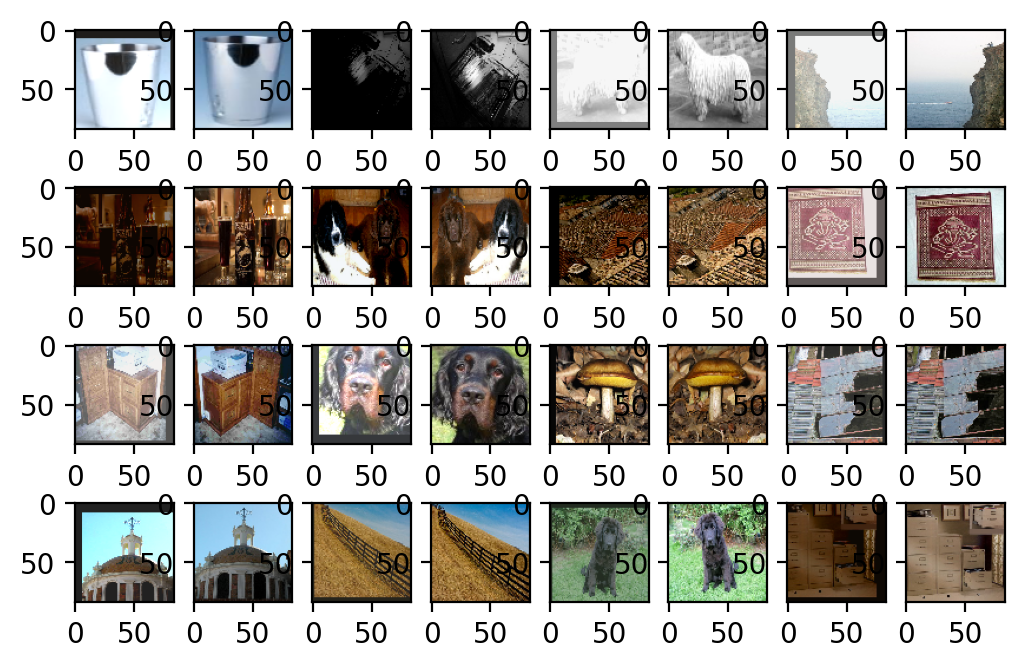

In [64]:
import matplotlib.pyplot as plt

# otro_x = next(iter(train_sampler))[0]
# otro_x_aug = augment(rng, otro_x)

fig, axes = plt.subplots(ncols=8, nrows=4, dpi=200)
for i in range(16):
    ax1 = axes[i // 4][(2 * i) % 8]
    ax2 = axes[i // 4][(2 * i + 1) % 8]
    ax1.imshow(otro_x_aug[i])
    ax2.imshow(otro_x[i])

In [ ]:
otro

In [105]:
from lib import xe_and_acc
from test_utils import SupervisedStandardTester
from test_utils import SupervisedCosineTester

In [109]:
def pred_fn(slow_params, fast_params, slow_state, fast_state, rng, inputs, is_training, slow_apply, fast_apply):
    rng_slow, rng_fast = split(rng)
    slow_outputs, _ = slow_apply(slow_params, slow_state, rng_slow, inputs, is_training)
    fast_outputs, _ = fast_apply(fast_params, fast_state, rng_fast, *slow_outputs, is_training)
    return fast_outputs

def embeddings_fn(slow_params, slow_state, rng, inputs, is_training, slow_apply):
    return slow_apply(slow_params, slow_state, rng, inputs, is_training)[0][0]

In [16]:
no_stats_body, no_stats_head = prepare_model(
    cfg.dataset,
    output_size,
    cfg.model.hidden_size,
    cfg.model.activation,
    track_stats=False,
)
rng, rng_params = split(rng)
(untrained_slow_params, untrained_fast_params, untrained_slow_state, untrained_fast_state,) = make_params(
    rng, cfg.dataset, no_stats_body.init, no_stats_body.apply, no_stats_head.init, device,
)
# params = (slow_params, fast_params)
# state = (slow_state, fast_state)

In [111]:
test_pred_fn = jit(partial(pred_fn, is_training=False, slow_apply=body.apply, fast_apply=head.apply))
# test_untrained_pred_fn = jit(partial(pred_fn, is_training=False, slow_apply=no_stats_body.apply, fast_apply=no_stats_head.apply))

In [18]:
test_embeddings_fn = jit(partial(embeddings_fn, is_training=False, slow_apply=body.apply))
test_untrained_embeddings_fn = jit(partial(embeddings_fn, is_training=False, slow_apply=no_stats_body.apply))

In [112]:
supervised_std_tester = SupervisedStandardTester(
    rng,
    sup_val_images,
    sup_val_labels,
    cfg.val.sup.batch_size,
    # pred_fn_test,
    preprocess_fn,
    device,
)

In [113]:
loss, acc = supervised_std_tester(partial(test_pred_fn, *params, *state, rng))
print("Trained loss acc:")
print(loss, acc)

Trained loss acc:
2.388757 0.3896875


In [21]:
loss, acc = supervised_std_tester(partial(test_untrained_pred_fn, untrained_slow_params, untrained_fast_params, untrained_slow_state, untrained_fast_state, rng))
print("Untrained loss acc:")
print(loss, acc)

Untrained loss acc:
10.442042 0.0


In [22]:
supervised_cosine_tester = SupervisedCosineTester(
    rng,
    sup_train_images,
    sup_train_labels,
    sup_val_images,
    sup_val_labels,
    cfg.val.sup.batch_size,
    preprocess_fn,
    device,
)

In [23]:
supervised_cosine_tester(partial(test_embeddings_fn, params[0], state[0], rng))

0.34953125

In [24]:
supervised_cosine_tester(partial(test_untrained_embeddings_fn, untrained_slow_params, untrained_slow_state, rng))

0.18390625

In [25]:
from test_utils import FSLLRTester

In [26]:
fsllr_tester = FSLLRTester(
    val_images,
    val_labels,
    25,
    250,
    5,
    5,
    15,
    preprocess_fn,
    device,
)

In [27]:
fsllr_tester(partial(test_embeddings_fn, params[0], state[0], rng), rng)

0.556

In [28]:
fsllr_tester(partial(test_untrained_embeddings_fn, untrained_slow_params, untrained_slow_state, rng), rng)

0.39770666666666665

In [29]:
from lib import cl_inner_loop

In [30]:
from test_utils import lr_fit_eval

In [31]:
import numpy as onp

In [32]:
class ContinualLearnerTester:
    def __init__(
        self,
        spt_images,
        spt_labels,
        qry_images,
        qry_labels,
        device,
        preprocess_fn,
        n_jobs=4,
    ):
        self.spt_images = spt_images
        self.spt_labels = spt_labels
        self.qry_images = qry_images
        self.qry_labels = qry_labels

        self.device = device
        self.preprocess_fn = preprocess_fn
        self.n_jobs = n_jobs

    def __call__(
        self,
        length,
        slow_params,
        fast_params,
        slow_state,
        fast_state,
        rng,
        slow_apply,
        fast_apply,
        loss_fn,
        opt,
    ):
        def apply_fn(slow_params, fast_params, slow_state, fast_state, inputs):
            slow_outputs, _ = slow_apply(slow_params, slow_state, rng, inputs, False)
            return fast_apply(fast_params, fast_state, rng, *slow_outputs, False)[0]

        spt_images = flatten(
            preprocess_fn(jax.device_put(self.spt_images[:length], device)), 1
        )
        spt_labels = flatten((jax.device_put(self.spt_labels[:length], device)), 1)
        qry_images = flatten(
            preprocess_fn(jax.device_put(self.qry_images[:length], device)), 1
        )
        qry_labels = flatten((jax.device_put(self.qry_labels[:length], device)), 1)

        adapted_fast_params, _, _, _, info = cl_inner_loop(
            slow_params,
            fast_params,
            slow_state,
            fast_state,
            opt.init(fast_params),
            rng,
            spt_images,
            spt_labels,
            False,
            slow_apply,
            fast_apply,
            loss_fn,
            opt.update,
        )

        spt_slow_outputs, _ = slow_apply(
            slow_params, slow_state, rng, spt_images, False
        )
        qry_slow_outputs, _ = slow_apply(
            slow_params, slow_state, rng, qry_images, False
        )

        spt_outputs = fast_apply(
            adapted_fast_params, fast_state, rng, *spt_slow_outputs, False
        )[0]
        qry_outputs = fast_apply(
            adapted_fast_params, fast_state, rng, *qry_slow_outputs, False
        )[0]

        lr_spt_preds, lr_qry_preds = lr_fit_eval(
            onp.array(flatten(spt_slow_outputs[0], (1, 3))),
            onp.array(spt_labels),
            onp.array(flatten(qry_slow_outputs[0], (1, 3))),
            n_jobs=self.n_jobs,
            predict_train=True,
        )
        lr_spt_acc = (lr_spt_preds == spt_labels).astype(jnp.float32).mean()
        lr_qry_acc = (lr_qry_preds == qry_labels).astype(jnp.float32).mean()

        spt_acc = (spt_outputs.argmax(-1) == spt_labels).astype(jnp.float32).mean()
        qry_acc = (qry_outputs.argmax(-1) == qry_labels).astype(jnp.float32).mean()

        return spt_acc, qry_acc, lr_spt_acc, lr_qry_acc

In [33]:
cl_tester = ContinualLearnerTester(val_images[:, :10], val_labels[:, :10], val_images[:, 10:60], val_labels[:, 10:60], device, preprocess_fn)

In [39]:
inner_opt = ox.sgd(1e-1)
cl_tester(16, params[0], params[1], *state, rng, body.apply, head.apply, mean_xe_and_acc_dict, inner_opt)

(DeviceArray(0.2125, dtype=float32),
 DeviceArray(0.09875, dtype=float32),
 DeviceArray(1., dtype=float32),
 DeviceArray(0.345, dtype=float32))

In [40]:
inner_opt = ox.sgd(1e-3)
cl_tester(16, params[0], jax.tree_map(lambda x: jnp.zeros(x.shape), params[1]), *state, rng, body.apply, head.apply, mean_xe_and_acc_dict, inner_opt)

(DeviceArray(0.9125, dtype=float32),
 DeviceArray(0.32625, dtype=float32),
 DeviceArray(1., dtype=float32),
 DeviceArray(0.345, dtype=float32))

In [48]:
inner_opt = ox.sgd(1e-3)
cl_tester(16, untrained_slow_params, untrained_fast_params, untrained_slow_state, untrained_fast_state, rng, no_stats_body.apply, no_stats_head.apply, mean_xe_and_acc_dict, inner_opt)

(DeviceArray(0.2, dtype=float32),
 DeviceArray(0.09625, dtype=float32),
 DeviceArray(1., dtype=float32),
 DeviceArray(0.20375, dtype=float32))

In [54]:
inner_opt = ox.sgd(1e-3)
cl_tester(16, untrained_slow_params, jax.tree_map(lambda x: jnp.zeros(x.shape), params[1]), untrained_slow_state, untrained_fast_state, rng, no_stats_body.apply, no_stats_head.apply, mean_xe_and_acc_dict, inner_opt)

(DeviceArray(0.2375, dtype=float32),
 DeviceArray(0.10875, dtype=float32),
 DeviceArray(1., dtype=float32),
 DeviceArray(0.20375, dtype=float32))

In [58]:
transfer_cosine_tester = SupervisedCosineTester(
    rng,
    flatten(transfer_spt_images, 1),
    flatten(transfer_spt_labels, 1),
    flatten(transfer_qry_images, 1),
    flatten(transfer_qry_labels, 1),
    cfg.val.sup.batch_size,
    preprocess_fn,
    device,
)

In [59]:
transfer_cosine_tester(partial(test_embeddings_fn, params[0], state[0], rng))

0.478125

In [60]:
transfer_cosine_tester(partial(test_untrained_embeddings_fn, untrained_slow_params, untrained_slow_state, rng))

0.295625

In [121]:
import pickle

In [122]:
with open(osp.join(cfg.data_dir, "miniImageNet_category_split_train_phase_train.pickle"), "rb") as f:
    train_data = pickle.load(f, encoding='latin1')
    train_imgs = train_data['data']
    train_labels = train_data['labels']

In [135]:
with open(osp.join(cfg.data_dir, "miniImageNet_category_split_train_phase_val.pickle"), "rb") as f:
    val_data = pickle.load(f, encoding='latin1')
    val_imgs = val_data['data']
    val_labels = val_data['labels']

In [130]:
import numpy as onp

In [132]:
train_data["data"].shape, onp.array(train_labels).shape

((38400, 84, 84, 3), (38400,))

In [136]:
val_imgs.shape

(18748, 84, 84, 3)